In [5]:
import os
import copy
from __future__ import print_function

#os.add_dll_directory('C:\Windows\System32')

#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 
#import pyreadr
import scipy.io as sio
from itertools import combinations
from sklearn.model_selection import train_test_split

#Probabilistic programs
#!pip install pymc==5.0.2
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))



#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
#from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
#from graphviz import Source, Digraph
#import dot2tex as d2t
#from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az
import colorsys

# Image processing stuff
#!pip install opencv-python
import cv2

#User-defined functions (in the same folder as the notebook)
import my_fun as mf
import my_fun_acta_psy as mf2

Running on PyMC v5.1.0


# Numerosity
Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

## Probabilities and numerosity


Imagine that you have in front two urns with folded tickets. 

Urn one has 1 winning and 9 white tickets. 
Urn two has 10 winning and 90 white tickets.

It is clear that probabilities are the same. However, which urn do you think most people would chose?

Kirkpatrick & Epstein (1992)

You are going to see the probability of two events as fractions. Which one is more probable? Answer quickly, your first hunch.

$$ \frac{211}{617} \text{ vs.} \frac{227}{691}$$

In different formats (symbolic S, images NS, one-shot S, one-shot NS, many-shots PPP). Around 2/3 of the sample prefer loteries with a larger number of winning options 
<br> <br><br>

<center><img src="img/8_CB/alonso1.jpg" width = "401" height = '400'></center>

Alonso-Diaz, Piantadosi, Hayden, & Cantlon (2018)

What cognitive processes explain this bias?

**Fast thinking**
<center><img src="img/8_CB/FastSlow.png" width = "201" height = '200'></center>


**Low numerosity/education**
<center><img src="img/8_CB/OECD.png" width = "251" height = '250'></center>

**Wrong conceptual framework**

$$\frac{1}{2} + \frac{1}{4} = \frac{2}{6}$$


**Weird notation**

Same values different symbols
$$\frac{1}{2} = \frac{33}{66}$$

Same values same symbols
$$\frac{3}{3} = \frac{3}{3}$$

**Metabolic costs of computing ratios**

$$Posterior = \frac{Likelihood \times Prior}{Marginal}$$


<center> A Bayesian hypothesis </center>

Humans use all the available information (numerators and ratios). This is adaptive, perhaps optimal, if there is a large a prior probability that large fractions have large numerators.

Let's check the hypothesis by parts.

**Humans use all the available information (numerators and ratios)**


<center>Humans use all the available information (numerators and ratios)</center>

If you pick the black and white version, does it mean that you do not represent colors?
<br><br>
<center><img src="img/8_CB/alonso3.png" width = "751" height = '750'></center>

If you pick the right one, does it mean you do not represent ratios?

<center><img src="img/8_CB/alonso2.jpg" width = "751" height = '750'></center>

<center><img src="img/8_CB/alonso5.png" width = "751" height = '750'></center>

Experiment 2

* Top-down view of two bags. Orange wins. Which side do you pick to pull an orange ball?
* 10 probability distance between the bags
* 816 trials
* 21 participants (low n but the effect is present in all subjects, and replicable)

<center><img src="img/8_CB/alonso4.jpg" width = "451" height = '450'></center>

<center><img src="img/8_CB/alonso7.png" width = "551" height = '550'></center>

* Prob. distance effects suggests the existence of ratio representations
* Congruency effects confirm a whole-number bias
<center><img src="img/8_CB/alonso6.png" width = "551" height = '550'></center>

Now the Bayesian descriptive model

<center><img src="img/8_CB/model_WNB.svg" width = "651" height = '650'></center>

Assumption 1:
The decision depends on a lineal combination of numerosity ($W_{ir}$:winners, $L_{ir}$: losers) and ratio percepts ($\frac{W_{ir}}{W_{ir}+L_{ir}}$).

$$\beta_1 \Phi(W_{ir}) + \beta_2 \Phi(L_{ir}) + \beta_3 Ratio_{ir}$$

Null hypothesis: $\beta_3$ is centered around zero i.e. people do not compute or use ratios

Assumption 2:
Numerosity perception follows Weber's law

$$ \Phi(\#_{ir}) \sim N(\#_{ir}, Weber \times \#_{ir})$$


<center><img src="img/8_CB/Whalen.png" width = "651" height = '650'></center>
Whalen, et al, (1999)

Video explaining [Weber's law](https://www.youtube.com/watch?v=hHG8io5qIU8)




Assumption 3:
Stochastic choice:

$$\frac{e^A}{e^A+e^B}$$

where A is the lineal combination of percepts for the correct choice and B for the incorrect one

Now let's implement the model in PyMC

In [16]:
#Load data
#Performance: 0 wrong, 1 correct
#RT: response time in secs
#ProbRatio: small ratio / large ratio
#NumRatio: small numerator / large numerator
#DenRatio: small denominator / large denominator
#AreaCtl: dots across bags have 1: equal dot size, 2: equal cumulative area
#WinSide1: number of winners left bag
#WinSide2: number of winners right bag
#DenSide1: total balls left bag
#DenSide2: total balls right bag
#ProbSide1: probability of win left bag
#ProbSide2: probability of win right bag
#sideR: side of response; 1 left, 2 right, 0 no response.
#subID: subject identifier

WNB_all = pd.read_csv('data/8_CB/WNB.csv')
WNB_all['ProbDistance'] = np.abs(WNB_all['ProbSide1']-WNB_all['ProbSide2'])
WNB_all = WNB_all.loc[WNB_all['sideR']>0,:].reset_index(drop=True)

idx1 = WNB_all['ProbSide1']>=WNB_all['ProbSide2']
WNB_all['WinSmallRatio'] = int(0)
WNB_all['DenSmallRatio'] = int(0)
WNB_all['WinBigRatio'] = int(0)
WNB_all['DenBigRatio'] = int(0)
for i in range(WNB_all.shape[0]):
    if idx1[i]:
        WNB_all.loc[i,'WinSmallRatio'] = WNB_all.loc[i,'WinSide2']
        WNB_all.loc[i,'DenSmallRatio'] = WNB_all.loc[i,'DenSide2']
        WNB_all.loc[i,'WinBigRatio'] = WNB_all.loc[i,'WinSide1']
        WNB_all.loc[i,'DenBigRatio'] = WNB_all.loc[i,'DenSide1']
    else:
        WNB_all.loc[i,'WinSmallRatio'] = WNB_all.loc[i,'WinSide1']
        WNB_all.loc[i,'DenSmallRatio'] = WNB_all.loc[i,'DenSide1']
        WNB_all.loc[i,'WinBigRatio'] = WNB_all.loc[i,'WinSide2']
        WNB_all.loc[i,'DenBigRatio'] = WNB_all.loc[i,'DenSide2']
sID = WNB_all['subID'].unique()
subj_to_model = -1 #0 to 20; -1 for all
WNB = WNB_all
if subj_to_model>=0:
    WNB = WNB_all.loc[WNB_all['subID']==sID[subj_to_model],:].reset_index(drop=True) 
weber = 0.286679553540291 #mean value of participants (see paper)
winners_s = np.sort(WNB['WinSmallRatio'].unique())
winners_b = np.sort(WNB['WinBigRatio'].unique())
winners = np.sort(pd.concat([pd.Series(winners_s), pd.Series(winners_b)]).unique())
losers_s = np.sort((WNB['DenSmallRatio']-WNB['WinSmallRatio']).unique())
losers_b = np.sort((WNB['DenBigRatio']-WNB['WinBigRatio']).unique())
losers = np.sort(pd.concat([pd.Series(losers_s), pd.Series(losers_b)]).unique())
sn = np.array(WNB['WinSmallRatio'], dtype = str)
sd = np.array(WNB['DenSmallRatio'], dtype = str)
r = []
for idx, ele in enumerate(sn):
    r.append(ele + "_" + sd[idx])
bn = np.array(WNB['WinBigRatio'], dtype = str)
bd = np.array(WNB['DenBigRatio'], dtype = str)
for idx, ele in enumerate(bn):
    r.append(ele + "_" + bd[idx])
r = pd.Series(r).unique()
ratios = np.zeros((r.shape[0],3))
for idx, ele in enumerate(r):
    temp = np.array(ele.split("_"), dtype = int)
    ratios[idx,0] = temp[0] #num
    ratios[idx,1] = temp[1] #den
    ratios[idx,2] = temp[0]/temp[1] #ratio
print(winners.shape, losers.shape, ratios.shape)

#Indices (for vectors with unique values)
side1 = np.zeros((WNB.shape[0],3)) #column order: index for winners, losers, ratios
side2 = np.zeros((WNB.shape[0],3))
for i in range(WNB.shape[0]):
    #side 1
    w = WNB.loc[i, 'WinSmallRatio'] 
    den = WNB.loc[i, 'DenSmallRatio'] 
    l = den - w
    side1[i,0] = np.where(winners == w)[0][0]
    side1[i,1] = np.where(losers == l)[0][0]
    side1[i,2] = np.where((ratios[:,0] == w) & (ratios[:,1] == den))[0][0]
    
    #side 2
    w = WNB.loc[i, 'WinBigRatio'] 
    den = WNB.loc[i, 'DenBigRatio'] 
    l = den - w
    side2[i,0] = np.where(winners == w)[0][0]
    side2[i,1] = np.where(losers == l)[0][0]
    side2[i,2] = np.where((ratios[:,0] == w) & (ratios[:,1] == den))[0][0]
side1 = side1.astype(int)
side2 = side2.astype(int)

#choice data
idx1 = WNB['ProbSide1']>=WNB_all['ProbSide2']
idx2 = WNB['sideR'] == 1
WNB['correct'] = np.array((idx1 & idx2) | (~idx1 & ~idx2), dtype = int)
choice = WNB['correct'] #0: incorrect; 1: correct
#WNB

(21,) (23,) (75, 3)


In [17]:
with pm.Model() as WNB_model:
    
    #priors
    #percepts of winners and losers assumed different e.g. due to lose aversion
    Winners = pm.Normal('percept_winners', 
                        mu = winners, sigma = weber*winners, shape = winners.shape)
    Losers = pm.Normal('percept_losers', 
                       mu = losers, sigma = weber*losers, shape = losers.shape) 
    Ratios = pm.Beta('percept_ratios', 
                     alpha = ratios[:,0] + 1, 
                     beta = ratios[:,1] - ratios[:,0] + 1, shape = ratios.shape[0])
    Weight_win = pm.Uniform('weight_win', lower = -5, upper = 5)
    Weight_lose = pm.Uniform('weight_lose', lower = -5, upper = 5)
    Weight_ratio = pm.Uniform('weight_ratio', lower = 0, upper = 5)
    
    #print(Winners.tag.test_value.shape, 
    #      Losers.tag.test_value.shape,
    #      Ratios.tag.test_value.shape)

    
    #likelihood
    f_side1 = Weight_ratio*Ratios[side1[:,2]] + Weight_win*Winners[side1[:,0]] + Weight_lose*Losers[side1[:,1]]
    f_side2 = Weight_ratio*Ratios[side2[:,2]] + Weight_win*Winners[side2[:,0]] + Weight_lose*Losers[side2[:,1]]
    #f_side1 = Weight_win*Winners[side1[:,0]] 
    #f_side2 = Weight_win*Winners[side2[:,0]]
    softmax = pt.exp(f_side2)/(pt.exp(f_side1) + pt.exp(f_side2)) #prob. of picking side 2
    #a = tt.exp(np.random.rand(side1.shape[0]))
    #b = tt.exp(np.random.rand(side2.shape[0]))
    #softmax = a/(a + b) #prob. of picking side 2
    choice_LH = pm.Bernoulli('choice', p = softmax, observed = choice)

    #print(f_side1.tag.test_value.shape, f_side2.tag.test_value.shape,
    #      softmax.tag.test_value.shape, choice_LH.tag.test_value.shape)
    
    #sampling
    trace = pm.sample(1000, init = 'adapt_diag', tune=1500, idata_kwargs = {'log_likelihood': True})
    ppc = pm.sample_posterior_predictive(trace)
    #data = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [percept_winners, percept_losers, percept_ratios, weight_win, weight_lose, weight_ratio]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 627 seconds.
Sampling: [choice]


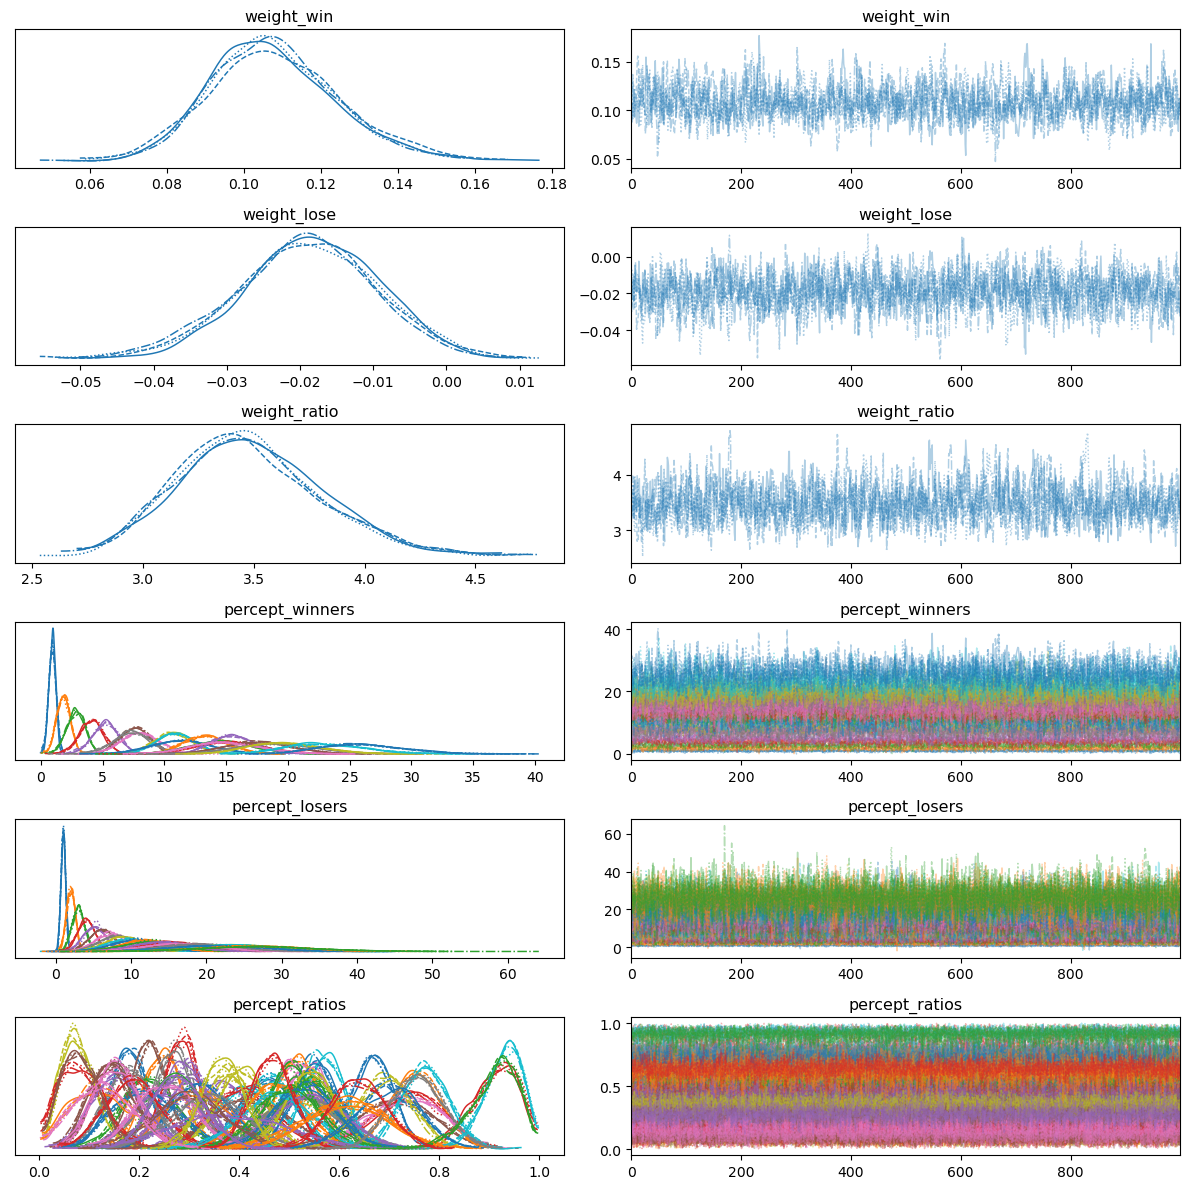

In [5]:
az.plot_trace(trace, var_names=['weight_win', 'weight_lose', 'weight_ratio', 
                               'percept_winners', 'percept_losers', 'percept_ratios'], compact=True);
plt.tight_layout()

Text(0.5, 1.0, '$\\beta_{ratios}$')

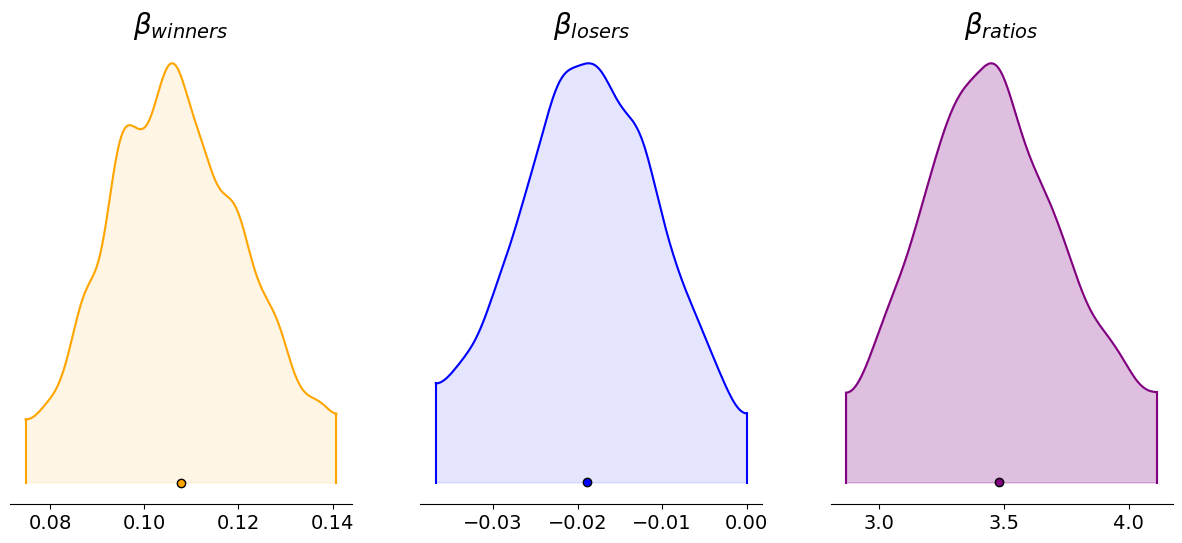

In [6]:
fig, ax = plt.subplots(1,3, figsize = [15,6])

az.plot_density(trace, var_names = ['weight_win'],
               shade=.1, ax = ax[0], hdi_prob=.95, colors = 'orange')
az.plot_density(trace, var_names = ['weight_lose'],
               shade=.1, ax = ax[1], hdi_prob=.95, colors = 'blue')
az.plot_density(trace, var_names = ['weight_ratio'],
               shade=.25, ax = ax[2], hdi_prob=.95, colors = 'purple')
#az.plot_density(
#    [trace['weight_win'], trace['weight_lose']],
#    data_labels=["$winners$", 
#                 "$losers$"],
#    shade=.1, ax = ax[0], hdi_prob=.95, 
#)
#az.plot_density(
#    [trace['weight_ratio']], hdi_prob=.95,
#    data_labels=["$\\beta_{ratio}$"], outline=True,
#    shade=.25, ax = ax[1], colors = 'purple', 
#)
ax[0].set_title('$\\beta_{winners}$', fontsize = 20)
ax[1].set_title('$\\beta_{losers}$', fontsize = 20)
ax[2].set_title('$\\beta_{ratios}$', fontsize = 20)
#ax[0].legend(['winners', 'losers'], loc='upper right');


#fig.savefig('img/8_CB/posterior_weights_WNB.svg')

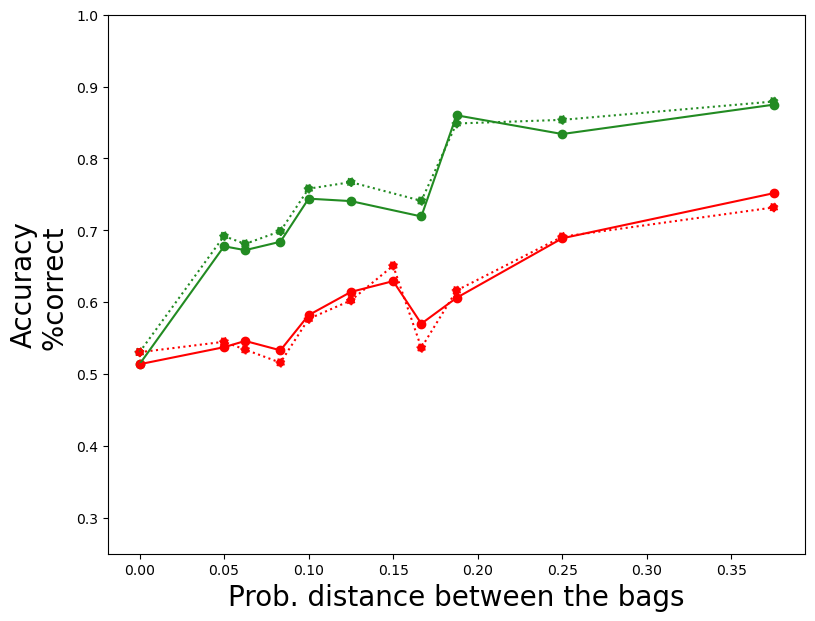

In [7]:
idx_cong = WNB['WinBigRatio']>WNB['WinSmallRatio'] #Congruent trial
idx_incong = ~idx_cong #Incongruent trial
temp = np.array(ppc.posterior_predictive['choice'])
temp = temp.reshape(temp.shape[0]*temp.shape[1],temp.shape[2])
ppc_cong = pd.concat([pd.DataFrame(temp.mean(axis=0)[idx_cong], columns = ['choice_model']), 
                      WNB.loc[idx_cong,:].reset_index(drop=True)], axis = 1)
ppc_incong = pd.concat([pd.DataFrame(temp.mean(axis=0)[idx_incong], columns = ['choice_model']), 
                        WNB.loc[idx_incong,:].reset_index(drop=True)], axis = 1)

#ppc_cong = pd.concat([pd.DataFrame(ppc['choice'].mean(axis=0)[idx_cong], columns = ['choice_model']), 
#                      WNB.loc[idx_cong,:].reset_index(drop=True)], axis = 1)
#ppc_incong = pd.concat([pd.DataFrame(ppc['choice'].mean(axis=0)[idx_incong], columns = ['choice_model']), 
#                        WNB.loc[idx_incong,:].reset_index(drop=True)], axis = 1)

toplot_cong = ppc_cong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
toplot_incong = ppc_incong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
idx1 = toplot_cong['ProbDistance']==0
idx2 = toplot_incong['ProbDistance']==0
mean0 = (toplot_cong.loc[idx1,'correct'] + toplot_incong.loc[idx2,'correct'])/2
toplot_cong.loc[idx1,'correct'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'correct'] = mean0
mean0 = (toplot_cong.loc[idx1,'choice_model'] + toplot_incong.loc[idx2,'choice_model'])/2
toplot_cong.loc[idx1,'choice_model'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'choice_model'] = mean0

fig = plt.figure(figsize=[9,7])
plt.plot(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')

plt.plot(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red');

plt.ylim([0.25,1])
plt.xlabel('Prob. distance between the bags', fontsize = 20)
plt.ylabel('Accuracy\n%correct ', fontsize = 20);

#fig.savefig('img/8_CB/ppc_WNB.svg')

# Exercise
* Make a DAG for a model with uniform prior between 0 and 1 for the Weber fraction. 
    * Implement the model in PyMC. Is the posterior mean for the Weber fraction different from 0.28 (the one used in the original model)? If different, what does it means?
* Make a DAG of a hierarchical model with a normal(mu, sigma) prior for the Weber fraction for each subject. Put a uniform prior [0,1] on the hyperparameters mu and sigma. 

An alternative hypothesis is that people are strategic, 

If the denominator is equal (or almost), then just use numerators. Else, compare ratios

Soft threshold to use or not ratio

$$pUseRatio_i = \frac{1}{1+e^{-k(Thr-rDen_i)}}$$

$pUseRatio_i$: Probability of using ratio in trial i <br>
$k, \ Thr$: Sensibility and threshold, respectively. Free parameters <br>
$rDen_i$: ratio between the denominator of both bags ($Small_{ratio}/Big_{ratio}$)

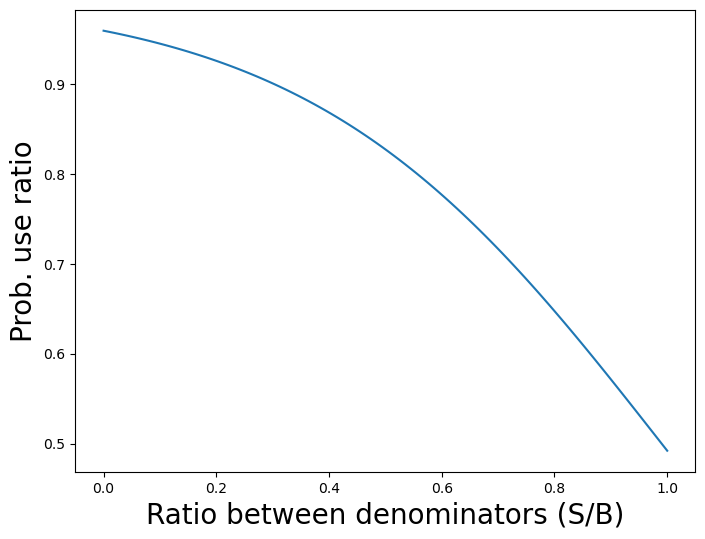

In [8]:
k = 3.2
Thr = 0.99
rDen = np.linspace(0,1,100)
pUseRatio = 1/(1+np.exp(-k*(Thr - rDen)))
plt.figure(figsize=(8,6))
plt.plot(rDen, pUseRatio);
plt.ylabel('Prob. use ratio', fontsize = 20)
plt.xlabel('Ratio between denominators (S/B)', fontsize = 20);

In [18]:
with pm.Model() as WNB_strategic_model:
    
    #priors
    k = pm.Uniform('k', lower=0, upper=20)
    Thr = pm.Uniform('Thr', lower=0, upper=1)
    #percepts of winners and losers assumed different e.g. due to lose aversion
    Winners = pm.Normal('percept_winners', 
                        mu = winners, sigma = weber*winners, shape = winners.shape)
    Losers = pm.Normal('percept_losers', 
                       mu = losers, sigma = weber*losers, shape = losers.shape) 
    Ratios = pm.Beta('percept_ratios', 
                     alpha = ratios[:,0] + 1, 
                     beta = ratios[:,1] - ratios[:,0] + 1, shape = ratios.shape[0])
    
    #likelihood 
    w_1 = Winners[side1[:,0]]
    w_2 = Winners[side2[:,0]]
    l_1 = Losers[side1[:,0]]
    l_2 = Losers[side2[:,0]]
    d_1 = w_1 + l_1
    d_2 = w_2 + l_2
    rDen = pt.switch( d_1>=d_2, d_2/d_1, d_1/d_2)
    pUseRatio = 1/(1+pt.exp(-k*(Thr-rDen)))  
    f_side1 = pUseRatio*Ratios[side1[:,2]] + (1-pUseRatio)*Winners[side1[:,0]] 
    f_side2 = pUseRatio*Ratios[side2[:,2]] + (1-pUseRatio)*Winners[side2[:,0]] 
    softmax = pt.exp(f_side2)/(pt.exp(f_side1) + pt.exp(f_side2)) #prob. of picking side 2
   
    choice_LH = pm.Bernoulli( 'choice', p = softmax, observed=choice)
    
    
    #print(f_side1.tag.test_value.shape, f_side2.tag.test_value.shape,
    #      softmax.tag.test_value.shape, choice_LH.tag.test_value.shape)
    
    #sampling
    trace_s = pm.sample(1000, init = 'adapt_diag', tune=1500, target_accept = 0.9, 
                        idata_kwargs = {'log_likelihood': True})
    ppc_s = pm.sample_posterior_predictive(trace_s)
    #data_s = az.from_pymc3(trace=trace_s)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, Thr, percept_winners, percept_losers, percept_ratios]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 761 seconds.
Sampling: [choice]


In [11]:
az.summary(trace_s)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
percept_winners[0],0.916,0.293,0.356,1.442,0.008,0.006,1316.0,1545.0,1.00
percept_winners[1],1.795,0.497,0.819,2.681,0.018,0.013,745.0,1042.0,1.01
percept_winners[2],1.751,0.687,0.280,2.852,0.022,0.016,1233.0,1496.0,1.00
percept_winners[3],2.773,0.589,1.638,3.849,0.010,0.007,3311.0,3274.0,1.00
percept_winners[4],3.245,0.523,2.282,4.214,0.014,0.010,1312.0,2190.0,1.00
...,...,...,...,...,...,...,...,...,...
percept_ratios[70],0.642,0.087,0.484,0.808,0.001,0.001,6770.0,2691.0,1.00
percept_ratios[71],0.612,0.082,0.459,0.768,0.001,0.001,6289.0,2942.0,1.00
percept_ratios[72],0.921,0.043,0.842,0.990,0.001,0.000,5468.0,2166.0,1.00
percept_ratios[73],0.739,0.082,0.586,0.885,0.001,0.001,5680.0,2854.0,1.00


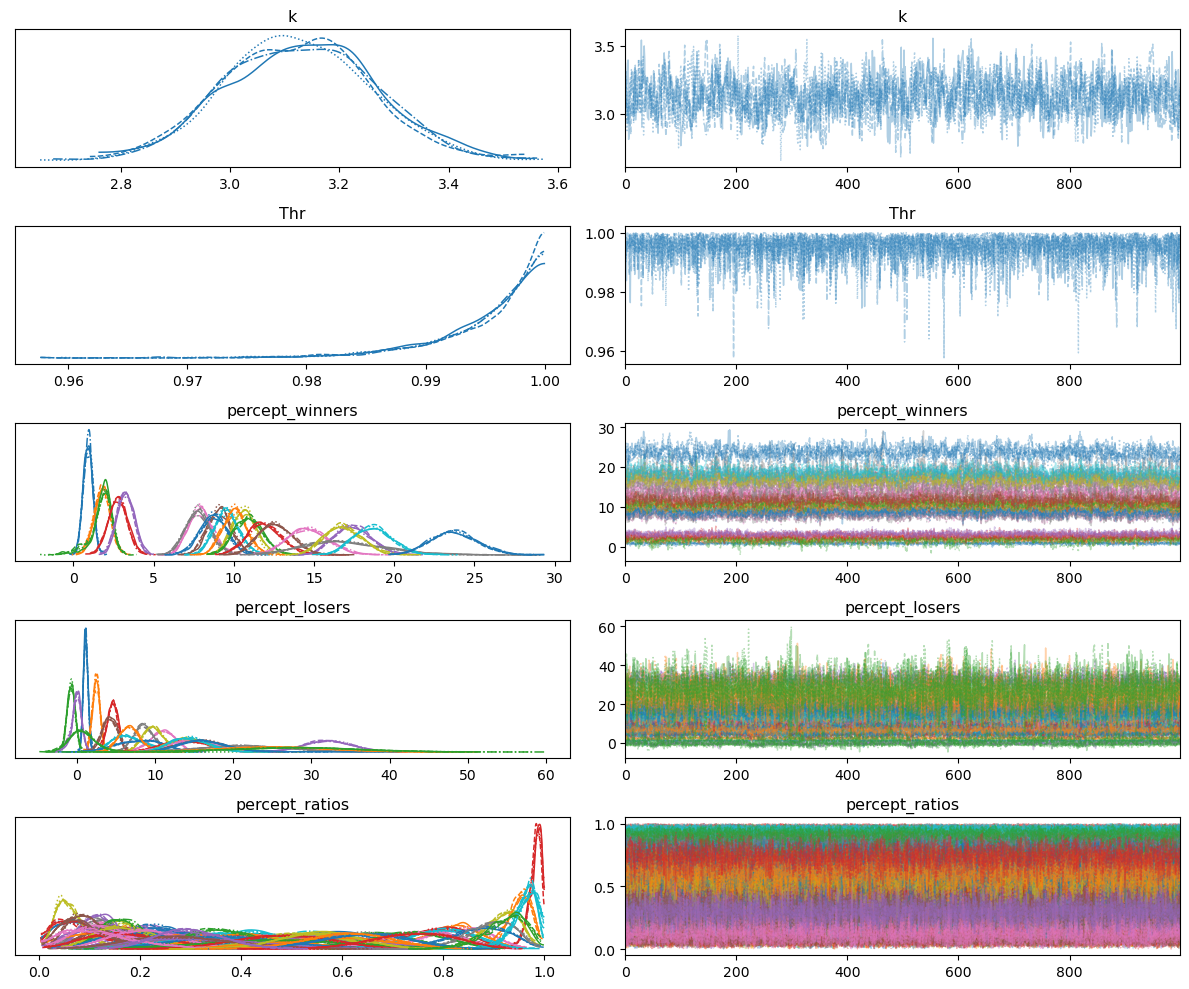

In [12]:
az.plot_trace(trace_s, var_names=['k', 'Thr', 
                               'percept_winners', 'percept_losers', 'percept_ratios'], compact=True);
plt.tight_layout()

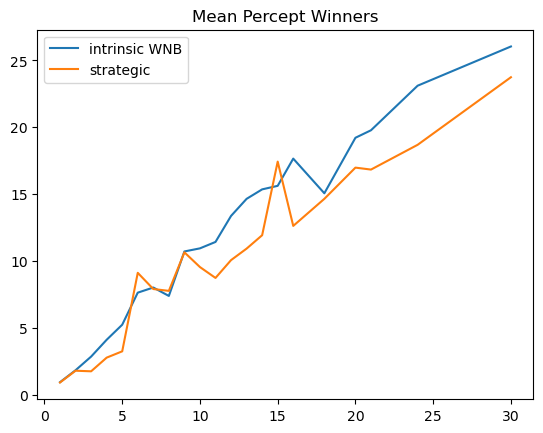

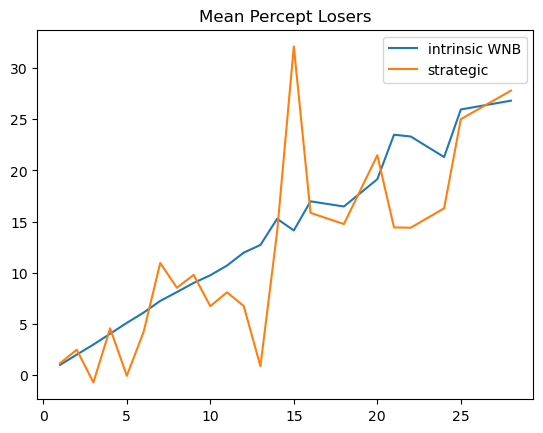

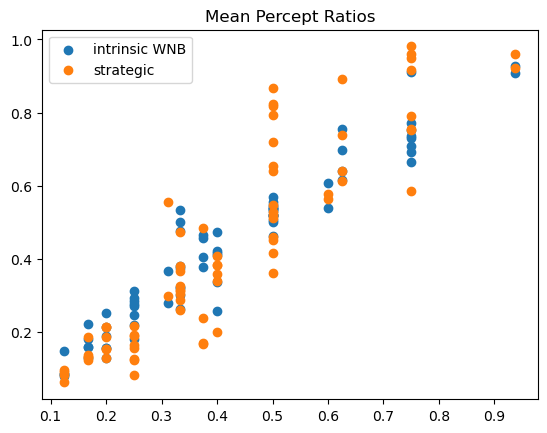

In [13]:
#y = trace['percept_winners'].mean(axis=0)
y = np.array(trace.posterior['percept_winners'])
y = y.reshape((y.shape[0]*y.shape[1], y.shape[2])).mean(axis=0)
x = winners
plt.plot(x,y, label = 'intrinsic WNB')

#y = trace_s['percept_winners'].mean(axis=0)
y = np.array(trace_s.posterior['percept_winners'])
y = y.reshape((y.shape[0]*y.shape[1], y.shape[2])).mean(axis=0)
plt.plot(x,y, label = 'strategic')
plt.legend()
plt.title('Mean Percept Winners')

plt.figure()
#y = trace['percept_losers'].mean(axis=0)
y = np.array(trace.posterior['percept_losers'])
y = y.reshape((y.shape[0]*y.shape[1], y.shape[2])).mean(axis=0)
x = losers
plt.plot(x,y, label = 'intrinsic WNB')

#y = trace_s['percept_losers'].mean(axis=0)
y = np.array(trace_s.posterior['percept_losers'])
y = y.reshape((y.shape[0]*y.shape[1], y.shape[2])).mean(axis=0)
plt.plot(x,y, label = 'strategic')
plt.title('Mean Percept Losers')
plt.legend();

plt.figure()
#y = trace['percept_ratios'].mean(axis=0)
y = np.array(trace.posterior['percept_ratios'])
y = y.reshape((y.shape[0]*y.shape[1], y.shape[2])).mean(axis=0)
x = ratios[:,2]
plt.scatter(x,y, label = 'intrinsic WNB')

#y = trace_s['percept_ratios'].mean(axis=0)
y = np.array(trace_s.posterior['percept_ratios'])
y = y.reshape((y.shape[0]*y.shape[1], y.shape[2])).mean(axis=0)
plt.scatter(x,y, label = 'strategic')
plt.title('Mean Percept Ratios')
plt.legend();


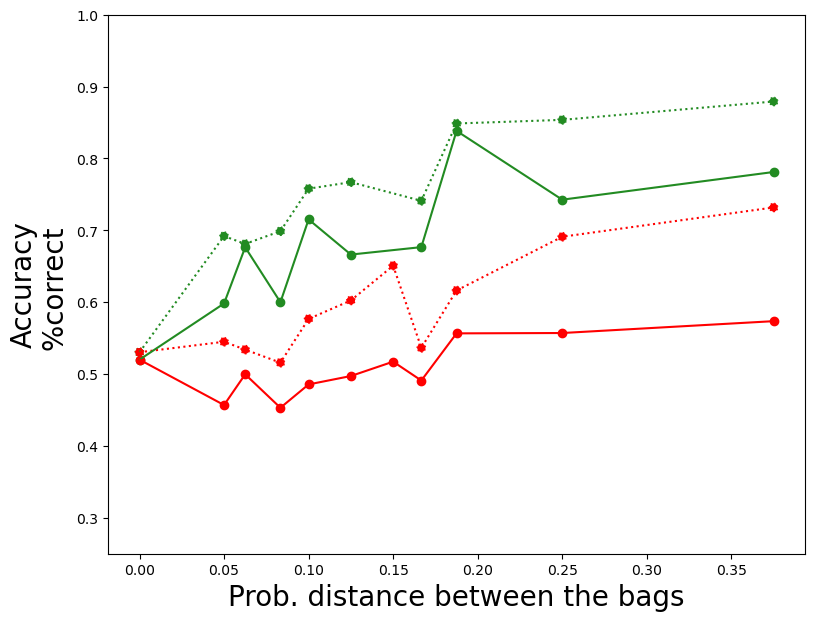

In [14]:
idx_cong = WNB['WinBigRatio']>WNB['WinSmallRatio'] #Congruent trial
idx_incong = ~idx_cong #Incongruent trial
temp = np.array(ppc_s.posterior_predictive['choice'])
temp = temp.reshape(temp.shape[0]*temp.shape[1],temp.shape[2])
ppc_cong = pd.concat([pd.DataFrame(temp.mean(axis=0)[idx_cong], columns = ['choice_model']), 
                      WNB.loc[idx_cong,:].reset_index(drop=True)], axis = 1)
ppc_incong = pd.concat([pd.DataFrame(temp.mean(axis=0)[idx_incong], columns = ['choice_model']), 
                        WNB.loc[idx_incong,:].reset_index(drop=True)], axis = 1)


#ppc_cong = pd.concat([pd.DataFrame(ppc_s['choice'].mean(axis=0)[idx_cong], 
#                                   columns = ['choice_model']), 
#                      WNB.loc[idx_cong,:].reset_index(drop=True)], axis = 1)
#ppc_incong = pd.concat([pd.DataFrame(ppc_s['choice'].mean(axis=0)[idx_incong], columns = ['choice_model']), 
#                        WNB.loc[idx_incong,:].reset_index(drop=True)], axis = 1)

toplot_cong = ppc_cong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
toplot_incong = ppc_incong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
idx1 = toplot_cong['ProbDistance']==0
idx2 = toplot_incong['ProbDistance']==0
mean0 = (toplot_cong.loc[idx1,'correct'] + toplot_incong.loc[idx2,'correct'])/2
toplot_cong.loc[idx1,'correct'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'correct'] = mean0
mean0 = (toplot_cong.loc[idx1,'choice_model'] + toplot_incong.loc[idx2,'choice_model'])/2
toplot_cong.loc[idx1,'choice_model'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'choice_model'] = mean0

fig = plt.figure(figsize=[9,7])
plt.plot(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')

plt.plot(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red');

plt.ylim([0.25,1])
plt.xlabel('Prob. distance between the bags', fontsize = 20)
plt.ylabel('Accuracy\n%correct ', fontsize = 20);

In [22]:
#Model comparison 
with WNB_strategic_model:
    strategic_waic = pm.waic(trace_s) #, var_name = 'choice')
with WNB_model:
    intrinsic_waic = pm.waic(trace) #This calculates the elpd_waic (-2 times is the waic in deviance scale) 

#lower is better
print('Strategy WAIC (deviance scale):      ', -2*strategic_waic.elpd_waic) 
print('Intrinsic WNB WAIC (deviance scale): ', -2*intrinsic_waic.elpd_waic)



Strategy WAIC (deviance scale):       21008.563578278314
Intrinsic WNB WAIC (deviance scale):  20308.104319673053


# Exercises

* Make the DAG of the strategic model
* Modify the WNB_model to check three alternative hypotheses:
    * People just compares winners (denominator neglect)
    * People compare winners and losers (just number)
    * People only use ratios (holistic ratios)
* Use WAIC to compare the 5 models (intrinsic WNB, Strategic, Denominator neglect, Just number, Holistic ratios). Which one is better? What does it mean for human behavior? (e.g.  why do you think the worse is the worse; or why the best is the best; why do humans behave like that).


We just estimated latent numerosity and ratio percepts with bayesian techniques ...

... but is fraction cognition bayesian? Maybe. Two arguments:

* Confidence follows bayesian predictions
* There is a prior in the world such that larger fractions haver larger numerators

Confidence follows bayesian predictions
<center><img src="img/8_CB/alonso15.png" width = "651" height = '650'></center>

Bayesian hypothesis: people should be more confident to otherwise identical ratios that have larger numerosities

<center><img src="img/8_CB/alonso9.png" width = "551" height = '550'></center>

Experiment: 
* Pick the bag with the higher probability of orange. 232 trials
* 100 mTurkers (final n = 82)
* 3 probability distances between the bags
* 2 conditions: cardinality (high and low) and congruency (cong. and incong)
* Post decision confidence 


<center><img src="img/8_CB/alonso10.png" width = "451" height = '450'></center>

<center><img src="img/8_CB/alonso11.png" width = "451" height = '450'></center>

Bags with high cardinality had fewer low confidence ratings (2)

Bags with low cardinality increase the amount of low confidence ratings (2)


<center><img src="img/8_CB/alonso12.png" width = "400" height = '400'></center>

Could it be an artifact of asking likert-type questions for confidence?

The same task but people chose by moving their fingers to a screen while an infrared records the tip of the finger

Assumption: the trajectory is a proxy of implicit confidence 

<center><img src="img/8_CB/alonso13.png" width = "551" height = '550'></center>

The trajectory was more confident with ratios with larger numbers (difficulty: 0.1)
<br><br>
<center><img src="img/8_CB/alonso14.svg" width = "451" height = '450'></center>

The overrall data is consistent with a Bayesian prediction:

<center><img src="img/8_CB/alonso9.png" width = "351" height = '350'></center>

Another clue that fraction cognition is bayesian, is a strong prior in reality
<br><br>
<center><img src="img/8_CB/alonso16.svg" width = "651" height = '650'></center>

Why the gap? Optimal? Yes, if numerators are a quick proxy of fractional value

<center><img src="img/8_CB/alonso6.png" width = "551" height = '550'></center>

According to Bayes,

$$p(RL|NL) = \frac{p(NL|RL)p(RL)}{p(NL)}$$

where R: ratio, N: numerator, D: denominator, L: larger, S: smaller.

To even suggest Bayesian optimality, we at least need that p(RL|NL) is larger than the other posteriors

$$p(RL|NL) > p(RL|NS) > p(RL|DL) > p(RL|DS)$$

In fact, if the magnitude of the ratio and denominator are independent, it is almost certain that this ordering occurs


In [23]:
#Generate counts for a specific category
folder_name = 'Warhol' #We included 4 folders as examples (go to Kaggle or Caltech256 website for others)
dirr = 'data/8_CB/Distribution-of-fractions/Example_Images/' + folder_name + '/'
name_files = [name for name in os.listdir(dirr) if (os.path.isfile(dirr+name)) & (name != '.DS_Store')]
n_files = len(name_files)

# Counts
results = mf2.img_counts(dirr, name_files, progress = False) #This takes a while
hue_bands = 4 #total number of hue bands (see img_counts)
NUM = [[], [], [], []]  # pixels of hue
DEN = [[], [], [], []]
NUM_B = [[], [], [], []]  # brightness of hue
DEN_B = [[], [], [], []]
NUM_S = [[], [], [], []]  # saturation of hue
DEN_S = [[], [], [], []]
for hb in range(hue_bands):
    NUM[hb].append(results[0][hb])
    DEN[hb].append(results[1][hb])
    
    NUM_B[hb].append(results[2][hb])
    DEN_B[hb].append(results[3][hb])
    
    NUM_S[hb].append(results[4][hb])
    DEN_S[hb].append(results[5][hb])


# Posteriors for all categories by HSV dimensions. 
# In "Example of one image category"  we show how we calculated
# posteriors. Specifically, see the function dropdown_callback 
# and the call to my_posterior in my_fun.py.

caltech256_h = pd.read_csv('data/8_CB/Distribution-of-fractions/tableCaltech_hue.csv')
caltech256_s = pd.read_csv('data/8_CB/Distribution-of-fractions/tableCaltech_sat.csv')
caltech256_v = pd.read_csv('data/8_CB/Distribution-of-fractions/tableCaltech_bright.csv')
paints_h = pd.read_csv('data/8_CB/Distribution-of-fractions/tablePaints_hue.csv')
paints_s = pd.read_csv('data/8_CB/Distribution-of-fractions/tablePaints_sat.csv')
paints_v = pd.read_csv('data/8_CB/Distribution-of-fractions/tablePaints_bright.csv')

In [24]:
# Random images to initialize (changeable in the widget below)
rnd1 = np.random.randint(n_files)
rnd2 = np.random.randint(n_files)
name_files.sort()
NUMS = [NUM, NUM_B, NUM_S]
DENS = [DEN, DEN_B, DEN_S]

wHue = widgets.Dropdown(options=[('Red-yellow', 0), ('Yellow-green', 1), ('Green-blue', 2), ('Blue-purple',3)],
                        value=3,
                        description='Hue band: ')
wDim = widgets.Dropdown(options=[('Hue', 'hue'), ('Saturation', 'saturation'), ('Brightness', 'brightness')],
                        value='hue',
                        description='HSV dimension: ')
wImg1 = widgets.Dropdown(options= name_files, value=name_files[rnd1], description='Image 1: ')
wImg2 = widgets.Dropdown(options= name_files,value=name_files[rnd2],description='Image 2: ')

out = widgets.interactive_output(mf2.dropdown_callback, 
                                 {'hue': wHue, 'hsv_dim': wDim, 
                                  'img1': wImg1, 'img2': wImg2, 
                                  'dirr': fixed(dirr), 'NUMS': fixed(NUMS), 'DENS': fixed(DENS)})

left_widgets = VBox([wHue, wDim])
right_widgets = VBox([wImg1, wImg2])
top = HBox([left_widgets, right_widgets])
VBox([top, out])

En imagenes ratio y denominador son independientes ($p(RL|DL=p(RL|DS)=0.5$). 

Dada esta condición, p(RL|NL) es muy alto en millones de comparaciones binarias de imagenes naturales y pinturas.
<br><br>
<center><img src="img/8_CB/alonso17.svg" width = "751" height = '750'></center>

No sólo en imagenes, también en muchos dominios p(RL|NL) es mayor (aunque la razón no es 100% clara pues $p(RL|DL\ne p(RL|DS)\ne 0.5$)
<br><br>
<center><img src="img/8_CB/alonso18.svg" width = "751" height = '750'></center>

We showed that:

* Using numerators does not imply not using ratios
* Confidence measurements are consistent with a Bayesian framework
* High prior probability that p(RL|NL).

Let's change topics

<center><img src="img/8_CB/LeeSarnecka1.svg" width = "751" height = '750'></center>

Number-knower theory. Children learn the first numerals (1 to aprox. 4) by trial and error (N-knower). If an adult asks for another numeral, even if the child knows the word, the child returns a random quantity.  

Then, at certain age, the children becomes a cardinal-principle knower (CP-knower), where succesive numerals indicate larger numbers. There is a jump/inference in the children's mind. 

<center><img src="img/8_CB/LeeSarnecka2.svg" width = "651" height = '650'></center>

$\pi$: base rate prob. of giving/reporting k objects back witout any demand e.g. "take 4 just because" (max: 15) <br>
$z_i$: N-knower level (PN-knower, one-knower, two-knower, three-knower, four-knower, and CP-knower) <br>
$q_{ij}^g, \ a_{ij}^g $: question and answer of child i in trial j <br>
$\pi_{jik}^{'}$: updated rate prob. of giving/reporting k objects back after the question <br>
>"... if three-knower is asked to give five, they become much less likely to give 1, 2, or 3, but equally relatively likely to give 4 and above." Lee & Wagenmakers, 2013 (pp. 238)

$\nu$: strength of the updating

<center><img src="img/8_CB/LeeSarnecka3.svg" width = "751" height = '750'></center>



In [6]:
## Models based in https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3
#load data
fa = pd.read_csv("data/8_CB/fa.csv") #answers (for fast-cards task) (rows: children; columns: trial)
fq = pd.read_csv("data/8_CB/fq.csv") #questions (for fast-cards task)
ga = np.array(pd.read_csv("data/8_CB/ga.csv")) #answers (for give-n task)
gq = np.array(pd.read_csv("data/8_CB/gq.csv")) #questions (for give-n task)
fnq = pd.read_csv("data/8_CB/fnq.csv")
gn = int(pd.read_csv("data/8_CB/gn.csv").iloc[0]) #max number of toys considered by the child (give-n task)
fn = 50 #max number of toys considered by the child (fast-cards task)
gnq = pd.read_csv("data/8_CB/gnq.csv")
ns = int(pd.read_csv("data/8_CB/ns.csv").iloc[0]) #number of subjects
nz = int(pd.read_csv("data/8_CB/nz.csv").iloc[0]) #proposed number-knower levels


In [7]:
ind5 = np.zeros((nz, gn, gn), dtype=int) 
#cells in ind5 have: three levels/indices of situations (see comment in ind5r below) by knower-level, number asked, number responded
for i in range(nz): #number-knower levels (z in the graphical model)
    i1 = i + 1
    for j in range(gn): #These loops creates a 3D array ind5 to implement pi_{ijk}
        j1 = j + 1
        for k in range(gn): 
            k1 = k + 1
            # Will be 1 if Knower-Level is Same or Greater than Answer
            ind1 = int(i1 - 1 >= k1)
            # Will be 1 for the Possible Answer that Matches the Question
            ind2 = int(k1 == j1)
            # Will be 1 for 0-Knowers
            ind3 = int(i1 == 1)
            # Will be 1 for CP-Knowers
            ind4 = int(i1 == nz)
            ind5[i, j, k] = (
                ind3
                + ind4 * (2 + ind2)
                + (1 - ind4) * (1 - ind3) * (ind1 * ind2 + ind1 + 1)
            )
            #for a zero-knower: 1
            #for a CP-knower for a k that matches question: 1*(2+1) = 3 
            #for a CP-knower for a k that doesn't matches question: 1*(2) = 2
            #for a N-knower for a k that matches question and knower level is enough: (1*1 + 1 + 1) = 3
            #for a N-knower for a k that doesn't matches question and knower level is enough:: (1+1) = 2 
            #for a N-knower for a k that matches question and knower level is not enough: (1) = 1
            #for a N-knower for a k that doesn't matches question and knower level is not enough: (1) = 1
            
ind5r = ind5 - 1 
#0: impossible number demand (first condition of pi_{ijk}) 
#1 too easy or number wasn't asked (third condition of pi_{ijk})
#2 just perfect, at limit of knower-level (second condition of pi_{ijk})
ga_obs = np.asarray(ga.flatten() - 1, dtype=int)
gq_obs = np.asarray(gq.flatten() - 1, dtype=int)
valid_ind = np.where(gq_obs != -1)[0] #to clean data, my guess is that 0 means children didn't respond?

In [8]:
with pm.Model() as model1:
    #priors
    pi = pm.Dirichlet("pi", a=pt.ones(gn), shape=gn)

    nu = pm.Uniform("nu", lower=1, upper=1000)
    nu_vec = pt.stack([1.0, #first condition of pi_{ijk} (before nu multiplication)
                       1.0 / nu, #third condition of pi_{ijk} (before nu multiplication)
                       nu]) #second condition of pi_{ijk} (before nu multiplication)

    piprime = pt.mul(nu_vec[ind5r], pi) #multiplication by nu
    npiprime = piprime / pt.sum(piprime, axis=-1, keepdims=True) #normalized pi prime for categorical likelihood

    zi = pm.Categorical("zi", p=pt.ones(nz) / nz, shape=ns) #knower level z per children s in dataset
    zi_vec = pt.repeat(zi, gq.shape[1]) #nz x number of questions 
    #print(zi_vec.tag.test_value.shape)
    
    #likelihoods
    pi_ij = npiprime[zi_vec[valid_ind], gq_obs[valid_ind], :]
    aij = pm.Categorical("aij", p=pi_ij, observed=ga_obs[valid_ind])
    
    #sampling
    trace1 = pm.sample(idata_kwargs = {'log_likelihood': True})
    ppc1 = pm.sample_posterior_predictive(trace1)
    #data1 = az.from_pymc3(trace=trace1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pi, nu]
>CategoricalGibbsMetropolis: [zi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 269 seconds.
/Users/santiagoalonsodiaz/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. In

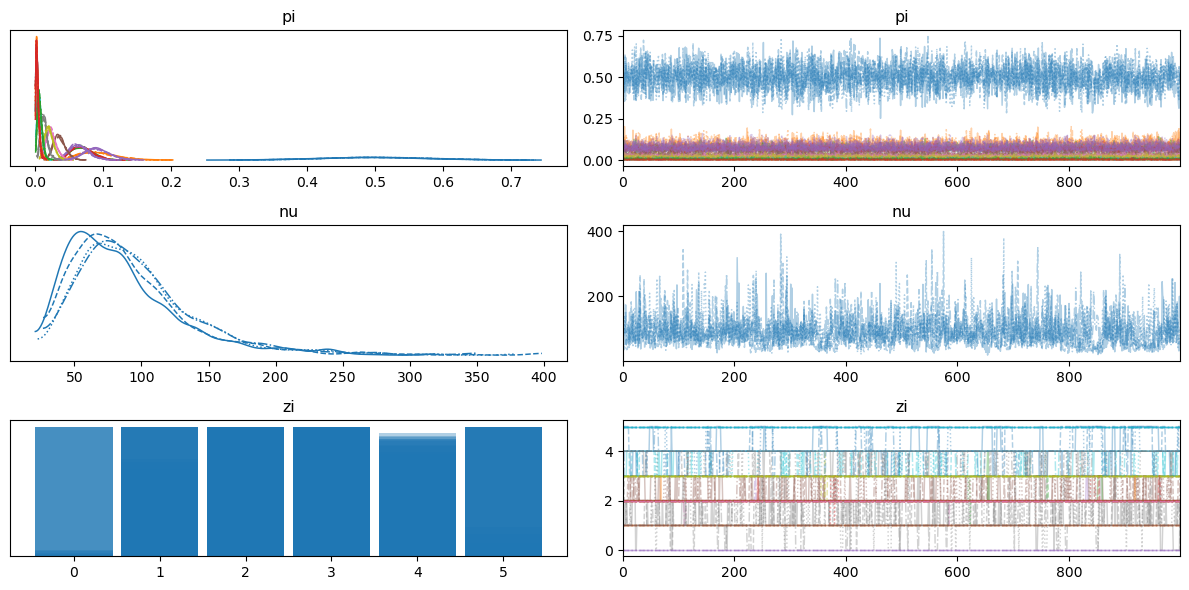

In [10]:
az.plot_trace(trace1,  var_names=["pi", "nu", "zi"], compact=True);
plt.tight_layout()

The posterior mean for pi (the probability of giving a number) is biased towards 1 and decays rapidly with an increment towards the end for giving all objects.

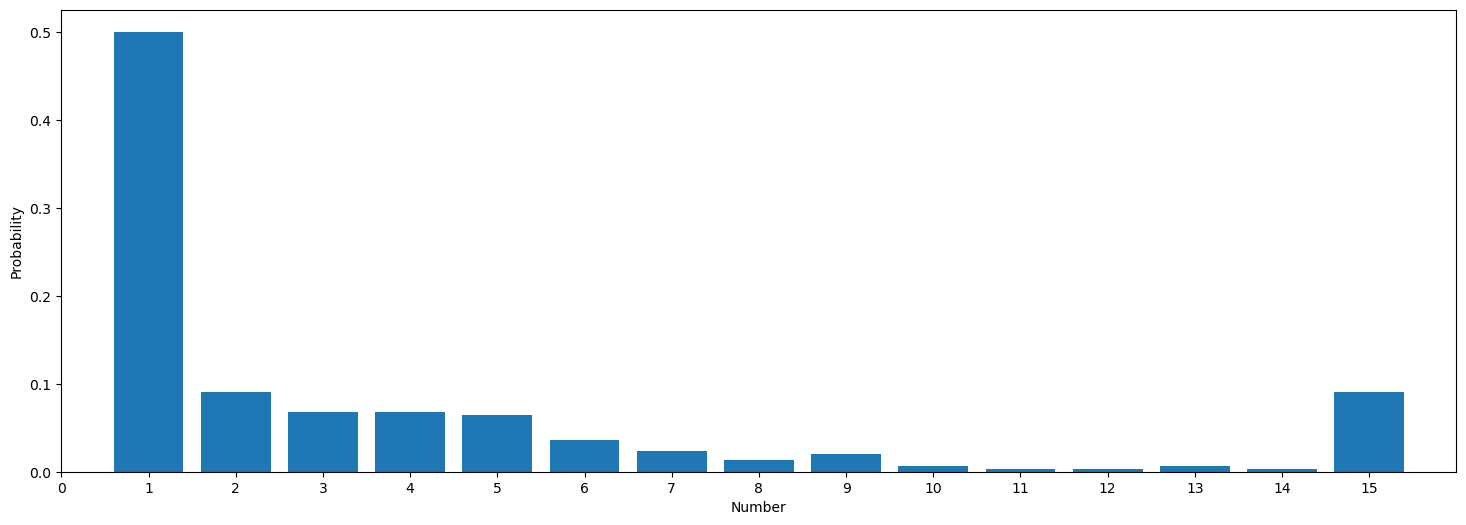

In [13]:
par = np.array(trace1.posterior["pi"])
sh = par.shape
pitr =  np.reshape(par, (sh[0]*sh[1],sh[2]) )

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(15) + 1, np.mean(pitr, axis=0), align="center")
plt.xlabel("Number")
plt.ylabel("Probability")
plt.xticks(np.arange(16))
plt.xlim([0, 16]);

For each child, the posterior is centered around an unique knower-level in all children.

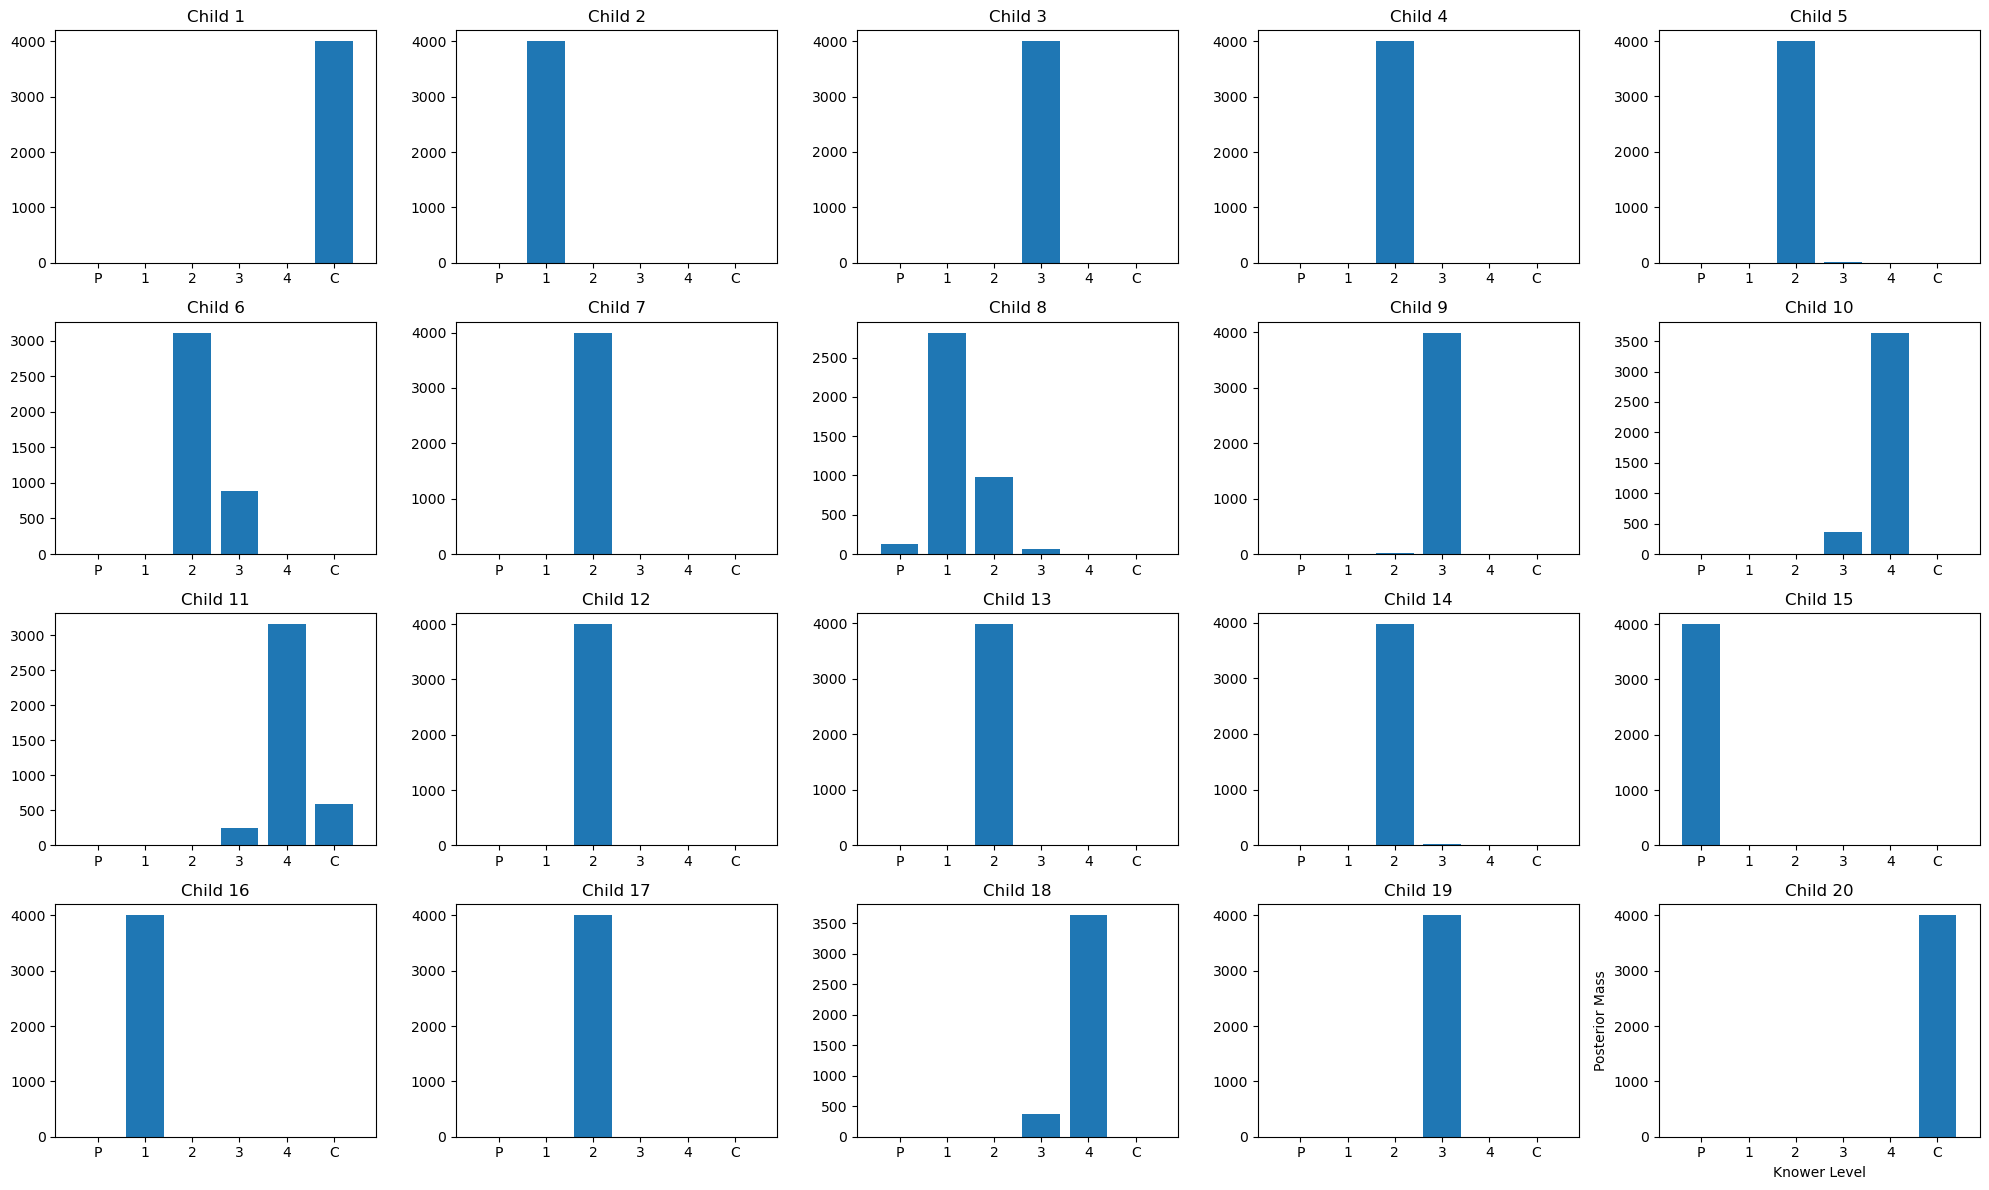

In [17]:
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
gs = axes.flatten()
par = np.array(trace1.posterior["zi"])
sh = par.shape
zitr = np.reshape(par, (sh[0]*sh[1],sh[2]))
for i in range(ns):
    ax = gs[i]
    bartmp = np.unique(zitr[:, i], return_counts=True)
    ax.bar(bartmp[0], bartmp[1])
    ax.set_title("Child %s" % (i + 1))
    ax.set_xlim([-0.9, 5.9])
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(["P", "1", "2", "3", "4", "C"])

#plt.subplot(gs[15])
plt.xlabel("Knower Level")
plt.ylabel("Posterior Mass")
plt.tight_layout();

In [23]:
# Generate posterior prediction for each subject
gqpred = np.tile(np.arange(gn)[np.newaxis, :], (ns, 1)).flatten()

# Generate posterior prediction for each knower level
zpred = np.tile(np.arange(gn)[np.newaxis, :], (nz, 1)).flatten()
z_vect = np.tile(np.arange(nz)[:, np.newaxis], (1, gn)).flatten()

nutr = np.array(trace1.posterior["nu"]).flatten()
tracelen = nutr.shape[0]
nsample = 500
predga = np.zeros((nsample, len(gqpred)))
predz = np.zeros((nsample, len(zpred)))
randlist = np.random.choice(tracelen, nsample)

In [24]:
def caterandom(p):
    return np.asarray([np.random.choice(len(p1), p=p1) for p1 in p])


for i, idx in enumerate(randlist):
    pi1, nu1, zi1 = pitr[idx], nutr[idx], zitr[idx] #tr stands for trace from the model

    nu_vec1 = np.stack([1.0, 1.0 / nu1, nu1])
    piprime1 = np.multiply(nu_vec1[ind5r], pi1)
    npiprime1 = piprime1 / np.sum(piprime1, axis=-1, keepdims=True)

    zi_vec2 = np.repeat(zi1, gn)
    pi_ij_pred = npiprime1[zi_vec2, gqpred, :]
    predga[i, :] = caterandom(pi_ij_pred)

    zi_ij_pred = npiprime1[z_vect, zpred, :]
    predz[i, :] = caterandom(zi_ij_pred)

We can predict how many objects a child will give. For example, child 20 is a CP-knower and the model predicts that she will always give the correct answer (red circles are the data, and warm colors indicate stronger probabilities for the model). 

Child 15 is a 0-knower, child 2 is a 1-knower, child 4 is a 2-knower, child 3 is a 3-knower, child 10 is a 4-knower (see previous plot).

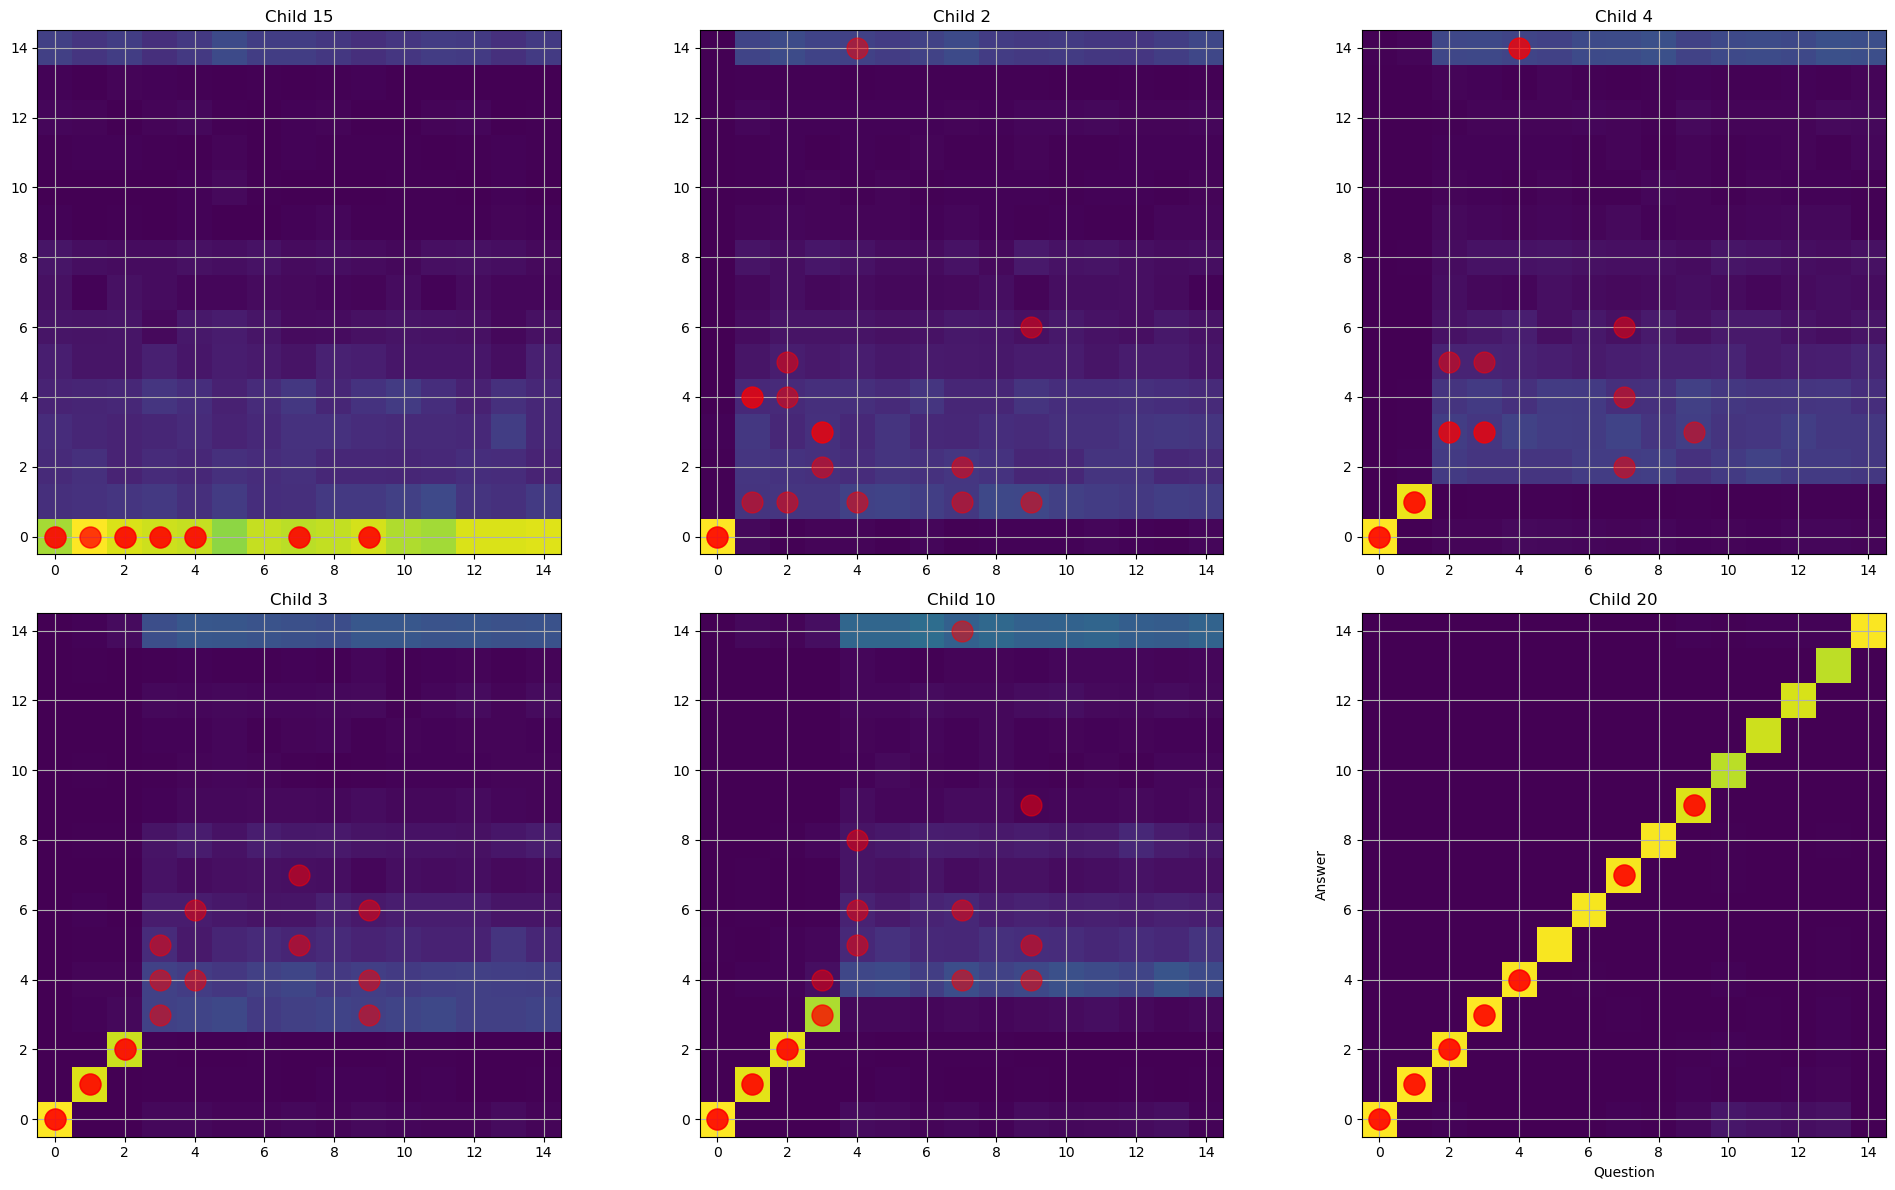

In [26]:
predga = np.reshape(predga, newshape=(nsample, ns, gn)).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
gs = axes.flatten()
subjlist = np.asarray([15, 2, 4, 3, 10, 20]) - 1

for i, isbj in enumerate(subjlist):
    mattmp = np.squeeze(predga[:, isbj, :])
    obs = ga[isbj] - 1
    qus = gq[isbj] - 1
    msk = qus != -1
    img_ = np.zeros((gn, gn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[j, bartmp[0]] = bartmp[1]
    ax = gs[i]
    ax.imshow(img_.T, cmap="viridis", origin="lower")
    ax.plot(qus[msk], obs[msk], "o", ms=15, color="r", alpha=0.5)
    ax.grid("off")
    ax.set_title("Child %s" % (isbj + 1))

#plt.subplot(gs[3])
plt.xlabel("Question")
plt.ylabel("Answer")
plt.tight_layout();

In general, the image shows the predictions of the model by knower-level. Follows our intuition: e.g. the yellow squares for a 3 knower go up to 3, then the blue colors get cooler.

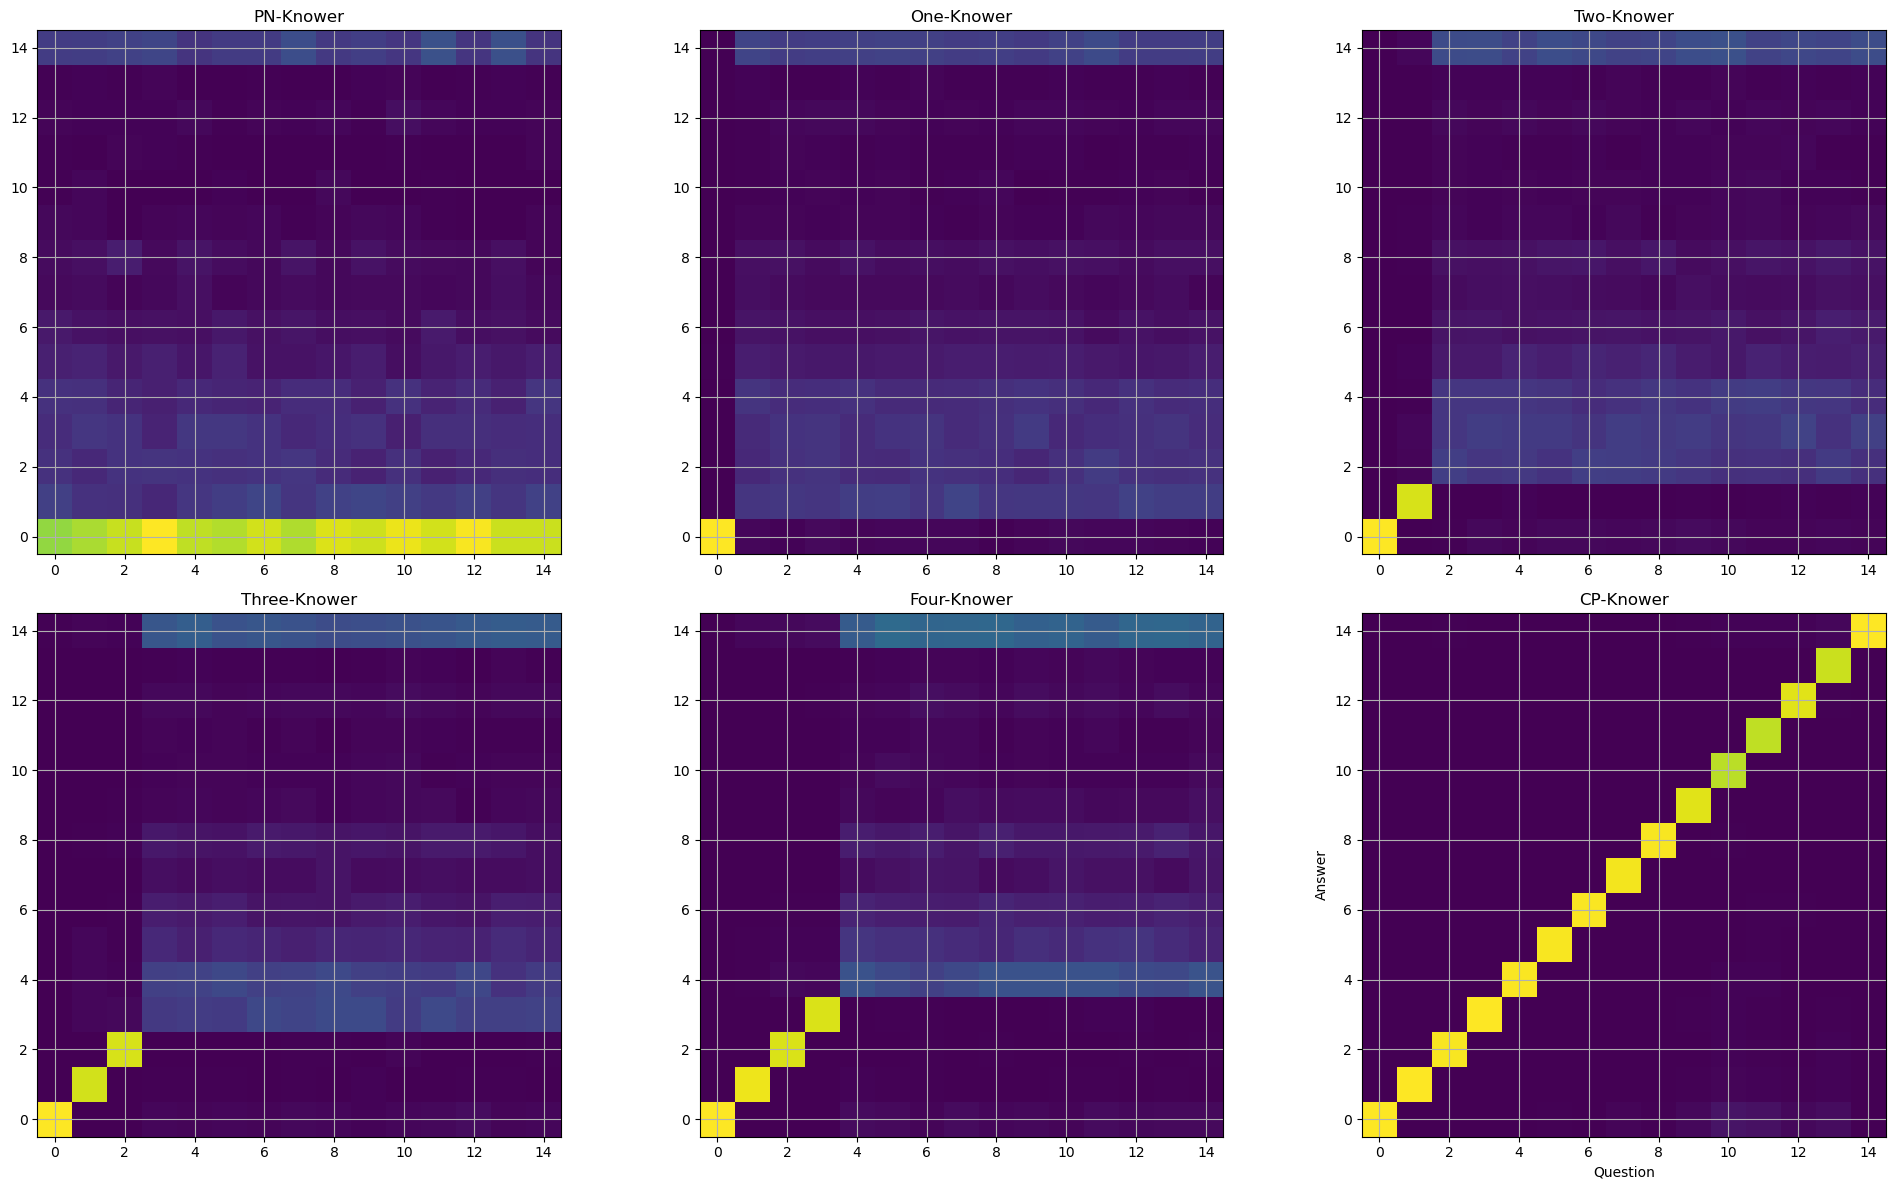

In [27]:
predz = np.reshape(predz, newshape=(nsample, nz, gn)).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
gs = axes.flatten()
knowertype = (
    "PN-Knower",
    "One-Knower",
    "Two-Knower",
    "Three-Knower",
    "Four-Knower",
    "CP-Knower",
)

for i in range(nz):
    mattmp = np.squeeze(predz[:, i, :])
    img_ = np.zeros((gn, gn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[j, bartmp[0]] = bartmp[1]
    ax = gs[i]
    ax.imshow(img_.T, cmap="viridis", origin="lower")
    ax.grid("off")
    ax.set_title(knowertype[i])

#plt.subplot(gs[3])
plt.xlabel("Question")
plt.ylabel("Answer")
plt.tight_layout();

# Exercises

* Make a graph that best represents the posterior of $pi$. Above only the average is plotted. 
* What do you think if we classify the knower-level of boys/girls using the maximum a posteriori (MAP) of the parameter zi? For example, what do you think of classifying child 8 as 1-knower? Think of an alternative to MAP


Why stages? Is this bayesian? Yes!

<center><img src="img/8_CB/Piantadosi1.svg" width = "651" height = '650'></center>

Suppose the brain has primitive operations (a language of thought)
<br><br>

<center><img src="img/8_CB/Piantadosi2.svg" width = "751" height = '750'></center>

Suppose that during development we find out how to combine these primitives. The child has to infer which combination is appropriate. He has to explore a huge hypothesis space. Here some.

<br><br>

<center><img src="img/8_CB/Piantadosi3.svg" width = "751" height = '750'></center>

As there is more data (exposure to numerical expressions) the posterior evolves through the stages that we see in boys and girls: from 1-knower to CP-Knower.

The data make some hypotheses more likely.


<center><img src="img/8_CB/Piantadosi4.svg" width = "751" height = '750'></center>

It depends on the data how we develop through the hypothesis space. This is seen in different cultures. The Tsimane in particular go slower (less exposure to numbers) but the same progression (Piantadosi, et al, 2014).

<br><br>
<center><img src="img/8_CB/Piantadosi5.svg" width = "551" height = '550'></center>

# Conclusion

* With Bayes tools you can describe numerical behavior (adults and minors).
* With Bayes tools you can also test Bayesian numerical behavior. 

# Appendix

In [ ]:
#Intrinsic whole number bias
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Whole Number Bias";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.25, width=0.25, lblstyle="font=\\small"];\
           /* links */\
           w -> pw;\
           l -> pl;\
           w -> pratio;\
           l -> pratio;\
           pw -> choice;\
           pl -> choice;\
           pratio -> choice;\
           subgraph cluster0 {\
               margin = 10; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i trial$";\
               choice;\
               subgraph cluster1 {\
                   margin = 10; labeljust=l; lblstyle="font=\\small";\
                   style = rounded;\
                   label = "$r ratio = [Small, Big]$";\
                   w;\
                   pw;\
                   l;\
                   pl;\
                   pratio;\
               }\
           }\
           /* nodes */\
           w [label = "$W_{ir}$", fillcolor = gray, style = filled, shape = square];\
           l [label = "$L_{ir}$", fillcolor = gray, style = filled, shape = square];\
           pw [label = "$\Phi(W_{ir})$", shape = circle];\
           pl [label = "$\Phi(L_{ir})$", shape = circle];\
           pratio [label = "$Ratio_{ir}$", shape = circle];\
           choice [label = "$Choice_i$", fillcolor = gray, style = filled, shape = square];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/8_CB/model_WNB.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#distributions:
# \Phi(W_{ir}) \sim N(W_{ir}, Weber \times W_{ir})
# \Phi(L_{ir}) \sim N(L_{ir}, Weber \times L_{ir})
# Ratio_{ir} \sim Beta(W_{ir} + 1, L_{ir} + 1)
# Choice_i \sim Bernoulli(pSM_i)
# pSM_i = \frac{e^{f_{iB}}}{e^{f_{iB}}+e^{f_{iS}}}
# f_{ir} = \beta_1 \Phi(W_{ir}) + \beta_2 \Phi(L_{ir}) + \beta_3 Ratio_{ir}
# \beta_{num cues} Uniform(-5,5)
# \beta_{ratio cue} Uniform(0,5)

#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}